# Title TBD:

(c) 2020 Manuel Razo & Daniela Osorio. This work is licensed under a 
[Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). 
All code contained herein is licensed under an 
[MIT license](https://opensource.org/licenses/MIT).

In [2]:
import glob
import os
import pickle

# Numerical analysis libraries
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr

# Interface to Stan
import cmdstanpy
import arviz as az

# Find home directory for repo
import git
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

# Import plotting features
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("ticks")
sns.set_palette("colorblind", color_codes=True)
sns.set_context("paper")

# Magic command to plot inline
%matplotlib inline

#To graph in SVG (high def)
%config InlineBackend.figure_format="svg"

## Explanation of what we are doing here (by Daniela)

Explanation goes here...

### Exploratory Data Analysis

Before jumping into the analysis let's do a quick exploration of the data. First, we need to import the data form all enzymes into memory.

In [3]:
# List files to be read
files = glob.glob(f"{homedir}/data/processed/enzymes/*csv")

# Read all files into dataframe
df = pd.concat(map(pd.read_csv, files))
# Remove unnecessary column
df = df.drop('Unnamed: 0', axis=1)

# Print unique enzymes
print(f"enzymes: {df.Name.unique()}")
df.head()

enzymes: ['DddD' 'DddP' 'DddK' 'Alma1' 'DmdA' 'DddY' 'DddQ']


,Name,d34S,Replicate,Time_min,ID,f_R,Real_conc,minus_ln_f_R,d34S_approx,r34_approx,f34_approx,conc_s_cell_lysate,F34_approx_DMSP,R34_approx_DMSP,d34S_approx_DMSP
0,DddD,12.410000,b,0,DddD_0_b,1.000000,95.300000,0.000000,12.333627,0.045560,0.043574,37.508476,0.043645,0.045637,14.044276
1,DddD,11.498627,b,4,DddD_4_b,0.721417,68.750996,0.326539,11.433021,0.045519,0.043537,37.508476,0.043615,0.045604,13.312725
2,DddD,13.121328,b,11,DddD_11_b,0.497228,47.385801,0.698707,13.035989,0.045591,0.043603,37.508476,0.043768,0.045771,17.032980
3,DddD,12.707020,b,18,DddD_18_b,0.303706,28.943204,1.191694,12.626963,0.045573,0.043586,37.508476,0.043834,0.045843,18.640973
4,DddD,12.973279,b,25,DddD_25_b,0.241314,22.997230,1.421656,12.889847,0.045585,0.043597,37.508476,0.043926,0.045945,20.888524


Having imported the data, let's look at the plot of (Dani) (column `minus_ln_f_R`) vs. (Dani) (col `d34S_approx_DMSP`)

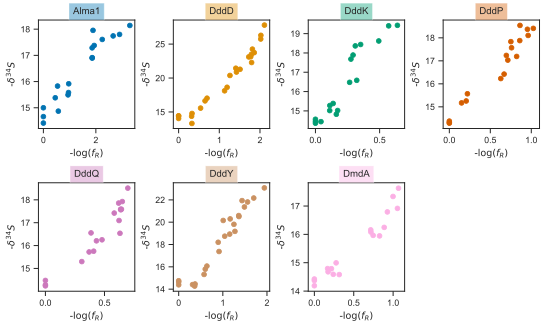

In [4]:
# Group data by enzyme
df_group = df.groupby("Name")

# Define colors
colors = sns.color_palette("colorblind", n_colors=len(df_group))
# Initialize figure
fig, ax = plt.subplots(2, 4, figsize=(9, 5))

# ravel ax
ax = ax.ravel()

# Loop through enzymes
for i, (enzyme, data) in enumerate(df_group):
    # Plot minus_ln_f_R vs d34S_approx_DMSP
    ax[i].scatter(data["minus_ln_f_R"], data["d34S_approx_DMSP"], color=colors[i])
    
    # Set plot title
    ax[i].set_title(f"{enzyme}", bbox=dict(facecolor=colors[i], alpha=0.4))
    
    # Set axis labels
    ax[i].set_xlabel(r"-$\log (f_R)$")
    ax[i].set_ylabel(r"-$\delta ^{34}S$")
    
# Increase spacing among subplots
plt.subplots_adjust(hspace=0.5, wspace=0.4)

# Remove last plot
ax[-1].axis("off");

We can see that, as expected, there is a linear correlation between (Dani) and (Dani). In order to compute the (Dani, fractionation factor?) we then need to estimate the slope of this linear regression. This, being one of the main results of our work, deserves a careful analysis. Therefore, rather than performing a simple ordinary least-squares or even a maximum likelihood estimate, we will perform a Bayesian linear regression to obtain this slope.

## Bayesian linear regression.

In Bayesian parameter inference we are concerned with learning the probability distribution over the quantities that parametrize our models. For the particular case of this linear regression let us define $x \equiv \log(f_R)$ and $y \equiv -\delta S^{34}$. Our simple linear regression model then takes the form of
$$
y_i = m x_i + b + \varepsilon_i,
$$
where $m$ is the slope we are interested in, $b$ is the $y-$axis intercept, and $\varepsilon_i$ is a random error associated with the intrinsic experimental errors. We take these errors to be random, i.e., we can only describe them probabilistically. As it is commonly done, we will assume that these errors are normally distributed, i.e.,
$$
\varepsilon_i = y_i - (m x_i + b) \sim \mathcal{N}(0, \sigma^2).
$$
What this equation is telling us is that we expect the random errors to have a mean of zero (positive and negative errors are equally likely, canceling each other), and they are characterized by an unknown variance $\sigma^2$.

So the objective of our Bayesian regression is to compute the so-called posterior probability distribution $P(m, b, \sigma^2 \mid D)$, where $D \equiv \{y_1, y_2, \ldots, y_N \}$, is the data. We can then write Bayes theorem as
$$
P(m, b, \sigma^2 \mid D) = \frac{P(D \mid m, b, \sigma^2)P(m, b, \sigma^2)}{P(D)}
\propto P(D \mid m, b, \sigma^2)P(m, b, \sigma^2).
$$
For the second equality we ignore the denominator $P(D)$ since it does not depend on our parameter values, and therefore only serves as a normalization constant.

Let's now analyze the two relevant terms.

### The likelihood $P(D \mid m, b, \sigma^2)$

The likelihood term is called like this because it reflects how likely it is to observe our data $D$ given a particular choice of parameter values $m, b$, and $\sigma^2$. This term captures the imprecision of our experimental measurements. Since we cannot measure things perfectly, we can model the random deviations from our expectation probabilistically. 

The first thing we will assume is that all of our measurements are independent of each other. This is written mathematically as
$$
P(D \mid m, b, \sigma^2) = \prod_{i=1}^N P(y_i \mid m, b, \sigma^2),
$$
i.e., the multiplication of the individual likelihoods. We already established what this term $P(y_i \mid m, b, \sigma^2)$ looks like when we defined that the random errors $\varepsilon_i$ have a normal distribution. What this implies is that we have a likelihood of the form
$$
P(D \mid m, b, \sigma^2) = \prod_{i=1}^N \frac{1}{\sqrt{2 \pi \sigma^2}} 
\exp\left[\frac{(y_i - \hat{y}_i)^2}{2 \sigma^2}  \right],
$$
where $\hat{y}_i = m x_i + b$ is the expected value given the linear model.

### The prior $P(m, b, \sigma^2)$

The prior, as the name suggests, captures all information we have prior to performing any measurement. It is through the prior how we can include all of our domain expertise by establishing what is known about the parameters beforehand.

For our simple linear model we will use the so-called **non-informative priors**. Although in modern statistical literature there are many reasons for not to use such priors, for such a simple linear model they will allow us to make a lot of progress analytically. The first thing we will assume is that each of the parameters' priors are independent. This is
$$
P(m, b, \sigma^2) = P(m) P(b) P(\sigma^2).
$$

For both the slope $m$ and the intercept $b$ we will assume **uniform priors**. What this prior means is that every value within a range is equally likely. Mathematically this is expressed as
$$
P(m) = \frac{1}{m_\max - m_\min},
$$
where $m_\max$ and $m_\min$ are the maximum and minimum ranges that the slope could take. An equivalent distribution can be written for the slope. Finally, for the observation error $\sigma^2$ we will assign the so-called Jeffreys' prior. This is the maximally non-informative prior for scale parameters such as $\sigma^2$. The prior takes the form
$$
P(\sigma^2) \propto \frac{1}{\sigma^2}.
$$

## The posterior distribution $P(m, b, \sigma^2 \mid D)$

Having established the likelihood and the prior, we can write down the posterior distribution. We will ignore all constant terms -for example both priors for $m$ and $b$- since they can be absorbed by the proportionality constant. After some algebra this results in
$$
P(m, b, \sigma^2 \mid D) =\frac{1}{\left(\sigma^{2}\right)^{\frac{N+2}{2}}} \exp \left[ \frac{-1}{2 \sigma^{2}} \sum_{i=1}^{N}\left(y_{i}-\left(b+m x_{i}\right)\right)^{2}\right].
$$
With this equation in hand we can now focus on integrating away the nuance parameters we don't care about.

### Marginal probability distribution of slope $P(m \mid D)$

In practice we do not care about the joint distribution of all parameters. What we care about is the probability distribution of individual parameters, for example the probability of the slope $m$ given the data $P(m \mid D)$. In order to compute this we need to integrate (marginalize) the other two parameters. This is written as
$$
P\left(m \mid D \right)=\int d b\; \int d\; \sigma^{2} P\left(m, b, \sigma^{2} \mid D \right).
$$
For the most part such integrals do not have analytical solutions and one has to make use of numerical approaches. But for the particular choice of priors and likelihood we have there is a closed-form solution. One can show that the result of this integral is a student-t distribution. More specifically we have that
$$
m \mid y_{1}, \cdots, y_{N} \sim \mathrm{t}\left(N-2, \hat{m}, \frac{\hat{\sigma}^{2}}{\mathrm{S}_{x x}}\right),
$$
where $\hat{m}$ is the most likely parameter value,
$$
\hat{\sigma}^2 \equiv \sum_{i=1}^N \left( y_i - (\hat{m}x_i + \hat{b}) \right)^2,
$$
again having $\hat{b}$ being the best fit for the intercept, and 
$$
S_{xx} \equiv \sum_{i=1}^N \left(x_i - \bar{x}  \right)^2, \;
\bar{x} \equiv \frac{1}{N} \sum_{i=1}^N x_i.
$$
What this means is that all we have to do is find the most likely value for the slope $\hat{m}$, and we can compute the full marginal posterior distribution analytically.

A similar expression can be derived for the intercept $b$. The result for the marginal distribution $P(b \mid D)$ is also a student-t distribution. This of the form
$$
b \mid y_{1}, \cdots, y_{n} \sim \mathrm{t}\left(N-2, \hat{b}, \hat{\sigma}^{2}\left(\frac{1}{N}+\frac{\bar{x}^{2}}{\mathrm{S}_{x x}}\right)\right).
$$

These two expressions can be easily evaluated using `scipy.stats`. Let's go ahead and compute these for a single example enzyme.

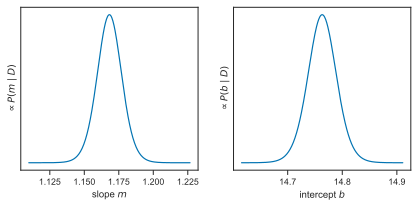

In [5]:
# Define enzyme
enzyme = "Alma1"
# Select example dataframe
df_example = df[df.Name == enzyme]

# Extract x and y data
x = df_example["minus_ln_f_R"]
y = df_example["d34S_approx_DMSP"]

# Fit 1D polynomial with numpy
# This is equivalent to finding the mean of the distribution
m_hat, b_hat = np.polyfit(x, y, 1)

# Define distribution parameters
n = len(df_example)  # number of datum
d_freedom = n - 2  # Degrees of freedom
sigma_sq = np.sum((y - (m_hat * x + b_hat))**2) / d_freedom  # mean squared error
S_xx = np.sum((x - np.mean(x))**2)  # sum of squares

# Compute error for slope
m_err = sigma_sq / S_xx
# Compute error for intercept
b_err = sigma_sq * (1 / n + np.mean(x)**2 / S_xx)

# Define range to evaluate slope distribution
m_range = np.linspace(0.95 * m_hat, 1.05 * m_hat, 300)
# Evaluate distribution
m_pdf = sp.stats.t.pdf(m_range, d_freedom, m_hat, m_err)

# Define range to evaluate intercept distribution
b_range = np.linspace(0.99 * b_hat, 1.01 * b_hat, 300)
# Evaluate distribution
b_pdf = sp.stats.t.pdf(b_range, d_freedom, b_hat, b_err)

# Initialize figure
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

# Plot slope distribution
ax[0].plot(m_range, m_pdf)
# Label axis
ax[0].set_xlabel(r"slope $m$")
ax[0].set_ylabel(r"$\propto P(m \mid D)$")
# Remove y axis ticks
ax[0].set_yticks([])

# Plot interecept distribution
ax[1].plot(b_range, b_pdf)
# Label axis
ax[1].set_xlabel(r"intercept $b$")
ax[1].set_ylabel(r"$\propto P(b \mid D)$")
# Remove y axis ticks
ax[1].set_yticks([])

# Adjust plot spacing
plt.subplots_adjust(wspace=0.2)

Here we have it. The full marginal posterior distribution for both the slope and the intercept. By eye, these distributions seem reasonable. One of the advantages of the Bayesian approach is the **interpretation** of the errors. In Bayesian lingo rather than declaring *confidence intervals*, one computes the so-called **credible regions**. These credible regions have the interpretation that is many time erroneously attributed to the confidence interval. For example, a 95% credible region has the interpretation that we place a 0.95 probability that the parameter value lies within the region contained in the interval.

Let's compute this 95% credible region for both parameters.

In [6]:
# Define percentiles
percentiles = [0.025, 0.975]

# Compute percentiles for slope
m_per = [sp.stats.t.ppf(x, d_freedom, m_hat, m_err) for x in percentiles]

# Compute percentiles for intercept
b_per = [sp.stats.t.ppf(x, d_freedom, b_hat, b_err) for x in percentiles]

# Print results
print(f"slope: {np.round(m_hat, 2)} + " +
      f"{np.round(m_per[1] - m_hat, 2)} - " +
      f"{np.round(m_hat - m_per[0], 2)}")

print(f"intercept: {np.round(b_hat, 2)} + " +
      f"{np.round(b_per[1] - b_hat, 2)} - " +
      f"{np.round(b_hat - b_per[0], 2)}")

slope: 1.17 + 0.02 - 0.02
intercept: 14.76 + 0.05 - 0.05


Let's then define a function that takes the data, and computes the percentiles for the slope, which is the quantity we care about.

In [7]:
def slope_regression(x, y, percentiles=[0.025, 0.05, 0.975]):
    """
    Function to compute the credible region of the slope "m" on a
    linear regression of the form y_i = m * x_i + b.
    Parameters
    ----------
    x : array-like
        x-values of the linear regression
    y : array-like
        y-values of linear regression
    percentiles : array-like. Default = [0.025, 0.05, 0.975]
        Percentiles of the posterior distribution to be computed
    Returns
    -------
    slope_percentiles : array-like
        Percentiles of the posterior distribution for the slope
    """
    # Fit 1D polynomial with numpy
    # This is equivalent to finding the mean of the distribution
    m_hat, b_hat = np.polyfit(x, y, 1)

    # Define distribution parameters
    n = len(x)  # number of datum
    d_freedom = n - 2  # Degrees of freedom
    sigma_sq = np.sum((y - (m_hat * x + b_hat))**2) / d_freedom  # mean squared error
    S_xx = np.sum((x - np.mean(x))**2)  # sum of squares

    # Compute error for slope
    m_err = sigma_sq / S_xx

    # Compute percentiles for slope
    return [sp.stats.t.ppf(x, d_freedom, m_hat, m_err) for x in percentiles]

With this function we can now evaluate this for all enzymes.

In [8]:
# Group data by enzyme
df_group = df.groupby("Name")

# Define percentles to compute
percentiles = [0.025, 0.5, 0.975]

# Initialize dataframe to save slope inferences
df_slope = pd.DataFrame(
    [], columns=["enzyme", "slope_min", "slope_mode", "slope_high"]
)

# Loop through enzymes
for enzyme, data in df_group:
    # Extract x and y data
    x = data["minus_ln_f_R"]
    y = data["d34S_approx_DMSP"]
    # Compute regression
    reg = slope_regression(x, y, percentiles)
    # Append to dataframe
    df_slope = df_slope.append(
        pd.Series([enzyme] + reg, index=df_slope.columns),
        ignore_index=True
    )

df_slope

,enzyme,slope_min,slope_mode,slope_high
0,Alma1,1.149526,1.168205,1.186884
1,DddD,5.788309,5.973506,6.158703
2,DddK,7.627873,9.088253,10.548632
3,DddP,3.865322,3.984789,4.104257
4,DddQ,4.850229,5.261780,5.673331
5,DddY,4.902735,5.092851,5.282968
6,DmdA,2.646655,2.712483,2.778311


## Plotting regression credible region

So far we computed the posterior distribution for the parameters. We would like to then perform the so-called *posterior predictive checks*. What this means is that, after inferring the parameter posterior distribution, we would like to see how would the model compare with the experimental data, including all the uncertainty in the parameter values. In other words, we would like to generate predictions for "unseen data $y_{N + 1}$." Again, for the particular choice of our priors and likelihoods, this prediction also has a closed-form solution. It can be shown that new data prediction are also student-t distributed. More specifically we have
$$
y_{N+1} \mid \text \{y_1, \ldots, y_N  \}, x_{N+1} \sim \mathrm{t}\left(N-2, \hat{\alpha}+\hat{\beta} x_{N+1}, \mathrm{S}_{Y \mid X_{N+1}}^{2}\right),
$$
where
$$
\mathrm{S}_{Y \mid X_{N+1}}^{2}=\hat{\sigma}^{2}+\hat{\sigma}^{2}\left(\frac{1}{N}+\frac{\left(x_{N+1}-\bar{x}\right)^{2}}{\mathrm{S}_{x x}}\right)=\hat{\sigma}^{2}\left(1+\frac{1}{N}+\frac{\left(x_{N+1}-\bar{x}\right)^{2}}{\mathrm{S}_{x x}}\right).
$$
Again, this is something we can easily evaluate using `scipy.stats`. Let's then make predictions for a range of $x$ values and plot both the most likely regression and the 95% credible region.

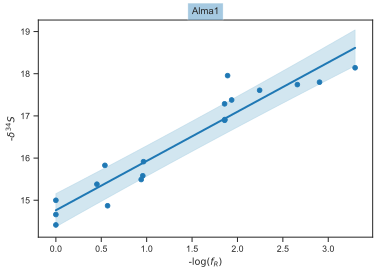

In [9]:
# Define enzyme
enzyme = "Alma1"
# Select example dataframe
df_example = df[df.Name == enzyme]

# Extract x and y data
x = df_example["minus_ln_f_R"]
y = df_example["d34S_approx_DMSP"]

# Fit 1D polynomial with numpy
# This is equivalent to finding the mean of the distribution
m_hat, b_hat = np.polyfit(x, y, 1)

# Define distribution parameters
n = len(df_example)  # number of datum
d_freedom = n - 2  # Degrees of freedom
sigma_sq = np.sum((y - (m_hat * x + b_hat))**2) / d_freedom  # mean squared error
S_xx = np.sum((x - np.mean(x))**2)  # sum of squares

# Define range of x values to evaluate
x_range = np.linspace(x.min(), x.max(), 200)

# Compute parameters for prediction distributions
y_hat = m_hat * x_range + b_hat
S_yx = sigma_sq * (1 + 1 / n + (x_range - np.mean(x))**2 / S_xx)

# Compute percentiles
y_low = sp.stats.t.ppf(0.025, d_freedom, y_hat, S_yx)
y_high = sp.stats.t.ppf(0.975, d_freedom, y_hat, S_yx)
y_mode = sp.stats.t.ppf(0.5, d_freedom, y_hat, S_yx)

# Define colors
colors=sns.color_palette("Paired", n_colors=2)

# Plot regression
plt.fill_between(x_range, y_low, y_high, alpha=0.5, color=colors[0])
plt.plot(x_range, y_mode, lw=2, color=colors[1])

# Plot data
plt.scatter(x, y, color=colors[1])

# Set plot title
plt.title(f"Alma1", bbox=dict(facecolor=colors[1], alpha=0.4))

# Set axis labels
plt.xlabel(r"-$\log (f_R)$")
plt.ylabel(r"-$\delta ^{34}S$");

This looks great. Just as before, let's define a function that computes this confidence interval so that we can reproduce this analysis for all enzymes

In [10]:
def credible_region(x, y, percentiles=[0.025, 0.05, 0.975], n_points=100):
    """
    Function to compute the credible region of the regression of a
    linear regression of the form y_i = m * x_i + b.
    Parameters
    ----------
    x : array-like
        x-values of the linear regression
    y : array-like
        y-values of linear regression
    percentiles : array-like. Default = [0.025, 0.05, 0.975]
        Percentiles of the posterior distribution to be computed
    n_points : int. Default = 100
        Number of points to include in analysis.
    Returns
    -------
    regression percentile : array-like
        Percentiles of the posterior distribution for the linear regression
    """
    # Fit 1D polynomial with numpy
    # This is equivalent to finding the mean of the distribution
    m_hat, b_hat = np.polyfit(x, y, 1)

    # Define distribution parameters
    n = len(x)  # number of datum
    d_freedom = n - 2  # Degrees of freedom
    sigma_sq = np.sum((y - (m_hat * x + b_hat))**2) / d_freedom  # mean squared error
    S_xx = np.sum((x - np.mean(x))**2)  # sum of squares

    # Define range of x values to evaluate
    x_range = np.linspace(x.min(), x.max(), n_points)

    # Compute parameters for prediction distributions
    y_hat = m_hat * x_range + b_hat
    S_yx = sigma_sq * (1 + 1 / n + (x_range - np.mean(x))**2 / S_xx)

    # Initialize array to save percentiles
    per = np.zeros([n_points, len(percentiles) + 1])
    # Add x values to first column
    per[:, 0] = x_range
    
    # Loop through percentiles
    for i, p in enumerate(percentiles):
        # Compute percentiles
        per[:, i + 1] = sp.stats.t.ppf(p, d_freedom, y_hat, S_yx)
    
    # Compute percentiles for slope
    return per

Let's now apply the regression to all enzymes.

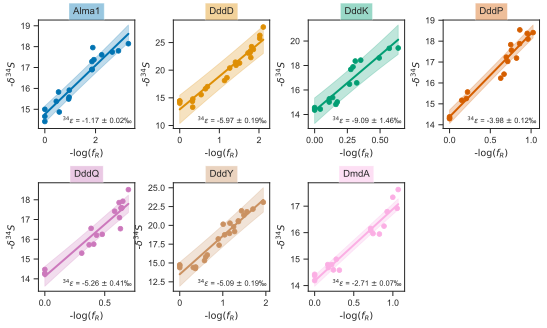

In [11]:
# Group data by enzyme
df_group = df.groupby("Name")

# Define colors
colors = sns.color_palette("colorblind", n_colors=len(df_group))
# Initialize figure
fig, ax = plt.subplots(2, 4, figsize=(9, 5))

# ravel ax
ax = ax.ravel()

# Loop through enzymes
for i, (enzyme, data) in enumerate(df_group):
    # Extract x and y data
    x = data["minus_ln_f_R"]
    y = data["d34S_approx_DMSP"]
    # Compute regression for slope
    m_reg = slope_regression(x, y, percentiles)
    
    # Compute credible region for linear regression
    lin_reg = credible_region(x, y, percentiles, 100)
    
    # Plot regression 
    # Plot regression
    ax[i].fill_between(
        lin_reg[:, 0], lin_reg[:, 1], lin_reg[:, 3], alpha=0.25, color=colors[i]
    )
    ax[i].plot(lin_reg[:, 0], lin_reg[:, 2], lw=2, color=colors[i])
    
    # Plot minus_ln_f_R vs d34S_approx_DMSP
    ax[i].scatter(x, y, color=colors[i])
    
    # Set plot title
    ax[i].set_title(f"{enzyme}", bbox=dict(facecolor=colors[i], alpha=0.4))
    
    # Add fractionation factor
    ax[i].text(
        0.25,
        0.05,
        r"$^{34}\varepsilon$ = " + f"{np.round(-m_reg[1],2)} $\pm$ {np.round(m_reg[1] - m_reg[0],2)}‰",
        transform = ax[i].transAxes,
        fontsize=7.5,
    )
    # Set axis labels
    ax[i].set_xlabel(r"-$\log (f_R)$")
    ax[i].set_ylabel(r"-$\delta ^{34}S$")
    
# Increase spacing among subplots
plt.subplots_adjust(hspace=0.5, wspace=0.4)

# Remove last plot
ax[-1].axis("off");

## Substrate degradation kinetics

Explanation for why this goes here...

### Exploratory Data Analysis

As in the previous section, let's first take a look at all of the data. Specifically want to take a look at how the substrate is being degraded over time.

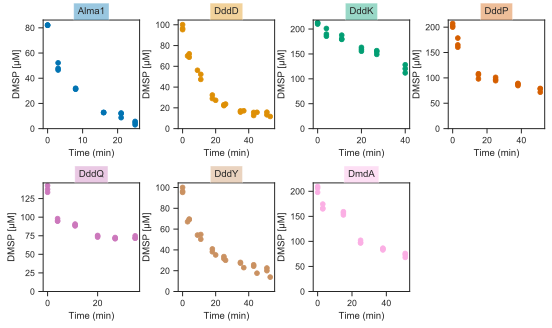

In [16]:
# Group data by enzyme
df_group = df.groupby("Name")

# Define colors
colors = sns.color_palette("colorblind", n_colors=len(df_group))
# Initialize figure
fig, ax = plt.subplots(2, 4, figsize=(9, 5))

# ravel ax
ax = ax.ravel()

# Loop through enzymes
for i, (enzyme, data) in enumerate(df_group):
    # Plot minus_ln_f_R vs d34S_approx_DMSP
    ax[i].scatter(data["Time_min"], data["Real_conc"], color=colors[i])
    
    # Set plot title
    ax[i].set_title(f"{enzyme}", bbox=dict(facecolor=colors[i], alpha=0.4))
    
    # Set axis labels
    ax[i].set_xlabel(r"Time (min)")
    ax[i].set_ylabel(r"DMSP [µM]")
    
    # Set plot ylim
    ax[i].set_ylim(bottom=0)
    
# Increase spacing among subplots
plt.subplots_adjust(hspace=0.5, wspace=0.4)

# Remove last plot
ax[-1].axis("off");

We can see a whole myriad of behaviors from the enzymes. Most of them seem to progress as expected, but others such as *DddP* go through two different phases. We will analyze these kinetics first assuming the simples possible model.

## Irreversible enzyme kinetics

In order to make sense of this data let's try to fit the simplest possible model that accounts for the enzyme kinetics. For this we will make the explicit assumption that there is no reversibility in our enzymatic reactions. What this means is that at all points we can assume that the rate at which the substrate is degraded is given by the rate of product production. This is given by
$$
\frac{dS}{dt} = -\frac{V_\max S}{K_M + S},
$$
where $S$ is the substrate concentration, $t$ is time, $V_\max$ is the maximum catalytic activity when the enzyme is saturated, and $K_M$ is the Michaelis-Menten constant. Our task is then to infer the value of both parameters, $V_\max$ and $K_M$. For this we will again use a Bayesian inference approach

### Bayesian inference of enzyme kinetics

As just mentioned, our task is to compute the probability distribution of both parameter values of our simple enzyme kinetics model. To have a more general inference we will include the initial substrate concentration $S_0$ as a parameter to be determined. This is because there is uncertainty associated with both the experiment, and the initial measurement of this quantity. In terms of Bayes theorem this is written as 
$$
P(V_\max, K_M, S_0 \mid D) \propto P(D \mid V_\max, K_M, S_0) P(V_\max, K_M, S_0),
$$
where $D$ are the time points at which the substrate concentration was measured. Let's looks into each of the terms.

#### Likelihood $P(D \mid V_\max, K_M, S_0)$

The first thing we need to distinguish is our theoretical expectation of the substrate concentration $S$, and the actual experimental measurement that we will define as $\tilde{S}$. The differential equation we wrote before for the substrate concentration is a **deterministic** model. That means that for any given input $S$ it can only compute one output. Our likelihood function should then account for the expected deviations that our measurements $\tilde{S}$ will have with respect to the theoretical expectations $S$. As is commonly done in practice, we will define the likelihood to be a Gaussian distribution with mean around the theoretical expectation, and standard deviation $\sigma^2$. This is written as
$$
\tilde{S}(t) \sim \mathcal{N}(S(t), \sigma^2),
$$
where $S(t)$ is given by
$$
S(t) = \int_0^t dt \; \frac{dS}{dt} = -\int_0^t dt \; \frac{V_\max S}{K_M + S}.
$$
In other words, we assume that our experimental measurement of the substrate concentration at time $t$, $\tilde{S}(t)$, will depart from the expected theoretical prediction $S(t)$ with a characteristic distance $\sigma^2$. This theoretical prediction at time $t$ is then computed by integrating the differential equation from time zero to the indicated time. Given that we do not have a closed-form solution for this integral, we well then use numerical integration to compute this expected quantity.

Furthermore, we will assume that each of the measurements in our dataset $D = \{\tilde{S}_0, \tilde{S}_1, \ldots, \tilde{S}_N \}$ are independent. This means that our likelihood then takes the explicit form
$$
P(D \mid V_\max, K_M, S_0, \sigma^2) = \prod_{i=1}^N P(\tilde{S}_i \mid V_\max, K_M, S_0, \sigma^2)
= \prod_{i=1}^N \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left[ - \frac{(\tilde{S}_i - S_i)^2}{2 \sigma^2} \right],
$$
where we added the term $\sigma^2$ to the likelihood since this nuance parameter needs to be included in the inference.

#### Prior $P(V_\max, K_M, \sigma^2)$

For our prior we will first assume that all parameters are independent of each other, i.e.
$$
P(V_\max, K_M, S_0, \sigma^2) = P(V_\max) P(K_M) P(S_0), P(\sigma^2).
$$
For the maximum catalytic rate $V_\max$ we do not have a specific prior information of what this value could be since this depends both on the enzyme properties, and the amount of enzyme in the cell lysate which we don't know. We could then use a maximally uniform prior as we did for the previous section. But for this case our posterior distribution, even if we were to use a non-informative prior, won't have an analytical solution. So the benefits of using such priors are lost because of how computationally problematic such priors are. We will then assign a weakly informative prior. These are the kind of priors that help our computation take place without the numerical pathologies that non-informative priors can have. More specifically we will chose a broad Half-normal distribution
$$
V\max \sim \text{Half-}\mathcal{N}(0, \sigma^2_{V_\max}),
$$
where we will choose $\sigma^2_{V_\max}$ to be broad enough such that the prior has no influence on the outcome. In other words, we are constraining $V_\max$ to be positive (that's why a half-Normal distribution centered at zero), but we are not putting a strict upper bound on which values this parameter could take.

For the Michaelis-Menten constant we have more prior information. Several papers in the literature (Dani, I would probably add the references at the end of the notebook) has characterized this parameter for the enzymes. We will then use an informative prior for $K_M$. More specifically we will assume that $K_M$ has a Gaussian prior of the form
$$
K_M \sim \mathcal{N}(\mu_{K_M}, \sigma^2_{K_M}),
$$
where $\mu_{K_M}$ and $\sigma^2_{K_M}$ are the values of the mean and variance reported in the references, respectively. **Note**: Not all enzymes have a reported variance. For those we will use a rule of thumb assuming $\approx$ 10\% error in the measurements.

In practice the reported Michaelis-Menten constant for all enzymes are orders of magnitude higher than the experimental substrate concentrations used in this work. This means that in practice we could approximate our original dynamics as
$$
\frac{dS}{dt} \approx \frac{V_\max}{K_M} S, \; \text{ for } $K_M \gg S.
$$
Therefore, the only value we should trust is the ratio of $V_\max / K_M$, since the particular value of $V_\max$ for the experiment will depend on both the amount of initial enzyme in the lysate, and the $K_M$ values reported in the literature.

For the initial concentration $S_0$ we will also assume a Gaussian prior. For simplicity we will take it to be
$$
S_0 \sim \mathcal{N}(\bar{S}_0, \sigma^2_{S_0}),
$$
where $\bar{S}_0$ is the mean initial concentration measured, and $\sigma^2_{S_0}$ is the experimental variance in this number.

Finally for the observation error $\sigma^2$ we will assume a half-Normal prior. This prior has the advantage compared to the Jeffreys' prior used in the previous section that it helps our sampler work properly. We chose a half-Normal distribution to allow the error to be arbitrarily close to zero without going into the forbidden negative values.

### The (untractable) posterior distribution $P(V_\max, K_M, S_0, \sigma^2 \mid D)$

Putting all terms together gives a quite complicated posterior distribution. As mentioned before, this distribution cannot be marginalized to obtain the individual parameter distributions, so we have to make use of numerical methods.

More specifically we will use state-of-the-art Markov Chain Monte Carlo (MCMC) in order to sample out of this posterior distribution. The advantage of using MCMC is that, by generating a biased random walk in the 4D parameter space of this particular inference problem, the times that a particular region in this parameter is visited by the walker is proportional to the probability of those parameters.

#### Implementing the inference

Now we have the theoretical foundations to implement this inference problem. The first thing we need to do is to import the previously mentioned prior information on the value of the Michaelis-Menten constants.

In [13]:
df_km = pd.read_csv("../../data/raw/enzymes_km_prior.csv")

df_km

,enzyme,km,sd_km,ref
0,Alma1,9000,900.0,TBD
1,DddY,850,NaN,TBD
2,DddD,4000,12.0,TBD
3,DmdA,5400,2300.0,TBD
4,DddP,13800,5500.0,TBD
5,DddK,13600,NaN,TBD
6,DddQ,22000,NaN,TBD


#### Setting up the MCMC sampler

For the MCMC samples we will use the state-of-the-art Markov Chain Monte Carlo sampler [`Stan`](https://mc-stan.org/users/documentation/). `Stan` implements an efficient Hamiltonian Monte Carlo sampler, allowing us to approximate numerically the posterior distribution. Since `Stan` uses compiled `C++` code it runs extremely fast. The downfall is that one has to use `Stan`'s native syntax in order to run the code. But we think that this is a small price to pay compared to the performance enhancement.

In the directory `stan_files` we have a file `michaelis_menten_inference.stan` that performs the sampling. This file requires the following inputs:
```
// Inference information
int<lower=1> n_replicate;  // number of replicates
int<lower=1> n_sample;  // number of time samples
real t_sample[n_replicate, n_sample];  // time points observed
real s_[n_replicate, n_sample];  // data, substrate concentration
real t0;  // Initial time

//  Simulation information
int<lower=1> n_sim;  // number of time points for numerical integration
real t_sim[n_sim];  // time points for numerical integration

// Parameters for prior distributions
real vmax_param[2];  // parameters for prior dis. of V_max
real km_param[2];  // parameters for prior dis. of K_M
real s0_param[2];  // parameters for prior dis. of s0
real sigma_param[2];  // parameters for prior dis. of sigma^2 
```

Let's compile this into a dictionary. Unfortunately the Python interface to Stan `CmdStanPy` is still in early development, and there are some issues with data types. So we will have to go around converting `np.float` numbers into native `float` ones for this to work.

In [19]:
# Define example enzyme
enzyme = "Alma1"

# Extract example dataset
df_example = df[(df.Name == enzyme)]

# Group by replicate
df_group = df_example.groupby("Replicate")

# Extract number of samples per group
n_replicate = len(df_group)

# Extract number of samples per replicate
n_sample = [len(d.Time_min.unique()) for g, d in df_group][0]

# Set time and sample array
t_sample = np.zeros([n_replicate, n_sample])
s_ = np.zeros([n_replicate, n_sample])
for i, (g, d) in enumerate(df_group):
    # Sort data by time
    d = d.sort_values(by="Time_min")
    t_sample[i, :] = d.Time_min
    s_[i, :] = d.Real_conc

# Define initial time slightly below zero (required by Stan)
t0 = float(df_example.Time_min[0]- 1E-6)

# Define number of points for posterior predictive checks
n_sim = 200
# Define time points for posterior predictive checks
t_sim = [float(x) for x in
        np.linspace(
        df_example.Time_min.min(), df_example.Time_min.max(), n_sim
            )
        ]
# Extract values for the K_M prior
km_param = [
    float(df_km[df_km.enzyme == enzyme]["km"].values[0]),
    df_km[df_km.enzyme == enzyme]["sd_km"].values[0]
]
if np.isnan(km_param[1]):
    km_param[1] = km_param[0] * 0.1
else:
    km_param[1] = float(km_param[1])

# Extract parameters for initial concentration
s0_param = [float(s_[:, 0].mean()), float(s_[:, 0].std())]

# Extract parameters for sigma
sigma_param = [0, s_.std(axis=0).mean()]

data = {
    "n_sample": n_sample,
    "n_replicate": n_replicate,
    "t_sample": t_sample,
    "s_": s_,
    "t0": t0,
    "n_sim": n_sim,
    "t_sim": t_sim,
    "vmax_param": [0, 1000],
    "km_param": km_param,
    "s0_param": s0_param,
    "sigma_param": sigma_param,
}

Now we are ready to compile the `Stan` script.

In [15]:
sm = cmdstanpy.CmdStanModel(stan_file='stan_files/michaelis_menten_inference.stan')

INFO:cmdstanpy:compiling stan program, exe file: /Users/mrazomej/git/DMSP/code/analysis/stan_files/michaelis_menten_inference
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/mrazomej/git/DMSP/code/analysis/stan_files/michaelis_menten_inference


Having compiled the script, let's go ahead and sample. We will use 6 cores to run the process in parallel

In [20]:
# Define initial conditions
samples = sm.sample(
    data=data,
    chains=6,
    iter_warmup=1500,
    iter_sampling=1500,
)

# Convert samples to ArViz object
samples_post = az.from_cmdstanpy(posterior=samples)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:start chain 5
INFO:cmdstanpy:start chain 6
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 5
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 6


We can now take a look at the **posterior predictive checks**. As the MCMC algorithm was sampling out of the posterior distribution, it generated data that we would expect to see given the parameter values. So we can use all of this generated data to compute the most expected value for the substrate kinetics, as well as the credible region.

Let's go ahead and plot both of this things. The solid line will represent the most likely dynamics for the enzyme kinetics according to the model, while the shaded region will represent the 95% credible region, i.e., the region where we would expect 95% of our data to fall within given the inferred parameter values.

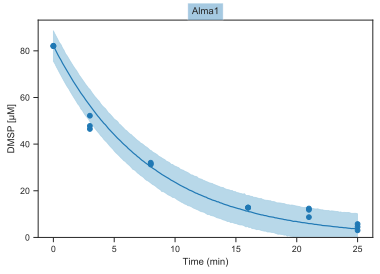

In [21]:
# Extract posterior predictive checks
s_tilde = samples_post.posterior["s_tilde"].stack(
    {"sample": ("chain", "draw")}
).transpose("sample", "s_tilde_dim_0")

# Define color
color = sns.color_palette("Paired", n_colors=2)
# Plot credible region
plt.fill_between(
    t_sim, 
    np.percentile(s_tilde, 50 - 95/2, axis=0),
    np.percentile(s_tilde, 50 + 95/2, axis=0),
    alpha=0.8,
    color=color[0]
)
# Plot mode
plt.plot(t_sim, np.percentile(s_tilde, 50, axis=0), color=color[1])

# Plot data
plt.plot(t_sample, s_, lw=0, marker="o", color=color[1])

# Set axis labels
plt.xlabel(r"Time (min)")
plt.ylabel(r"DMSP [µM]")

# Set title
plt.title("Alma1", bbox=dict(facecolor=color[1], alpha=0.4))

# Set y-axis limit
plt.ylim(bottom=0);

We can see that the model did a pretty good job of predicting the substrate kinetics for this particular enzyme. Most of the data falls within the 95% credible region and the trend looks reasonable.

Now we will implement this for all of the enzymes. We will save the results in memory given how computationally expensive this MCMC sampling is.

In [22]:
# Group data by enzyme
df_group = df.groupby("Name")

# Loop through enzymes
for enzyme, data in df_group:
    print(enzyme)
    # Defien asmple name
    file = f"../../data/mcmc/{enzyme}_mcmc.pkl"
    # Check if data already exists not to repeat the sample
    if os.path.isfile(file):
        continue
    else:
        # Group by replicate
        df_group = data.groupby("Replicate")

        # Extract number of samples per group
        n_replicate = len(df_group)

        # Extract number of samples per replicate
        n_sample = [len(d.Time_min.unique()) for g, d in df_group][0]

        # Set time and sample array
        t_sample = np.zeros([n_replicate, n_sample])
        s_ = np.zeros([n_replicate, n_sample])
        for i, (g, d) in enumerate(df_group):
            # Sort data by time
            d = d.sort_values(by="Time_min")
            t_sample[i, :] = d.Time_min
            s_[i, :] = d.Real_conc

        # Define initial time slightly below zero (required by Stan)
        t0 = float(data.Time_min[0]- 1E-6)

        # Define number of points for posterior predictive checks
        n_sim = 200
        # Define time points for posterior predictive checks
        t_sim = [float(x) for x in
                np.linspace(
                data.Time_min.min(), data.Time_min.max(), n_sim
                    )
                ]
        # Extract values for the K_M prior
        km_param = [
            float(df_km[df_km.enzyme == enzyme]["km"].values[0]),
            df_km[df_km.enzyme == enzyme]["sd_km"].values[0]
        ]
        if np.isnan(km_param[1]):
            km_param[1] = km_param[0] * 0.1
        else:
            km_param[1] = float(km_param[1])

        # Extract parameters for initial concentration
        s0_param = [float(s_[:, 0].mean()), float(s_[:, 0].std())]

        # Extract parameters for sigma
        sigma_param = [0, s_.std(axis=0).mean()]

        data_stan = {
            "n_sample": n_sample,
            "n_replicate": n_replicate,
            "t_sample": t_sample,
            "s_": s_,
            "t0": t0,
            "n_sim": n_sim,
            "t_sim": t_sim,
            "vmax_param": [0, 1000],
            "km_param": km_param,
            "s0_param": s0_param,
            "sigma_param": sigma_param,
        }
        print("Sampling with HMC")
        # Define initial conditions
        samples = sm.sample(
            data=data_stan,
            chains=6,
            iter_warmup=1500,
            iter_sampling=1500,
        )

        # Convert samples to ArViz object
        samples_post = az.from_cmdstanpy(posterior=samples)
        
        with open(file, 'wb') as f:
            pickle.dump(samples_post, f)
        
        print("Done!")

Alma1
DddD
DddK
DddP
DddQ
DddY
DmdA


We are now in position to show all of the posterior predictive checks for all enzymes. Again we will plot the most likely value for the enzyme kinetics as a solid line, and the shaded region will represent the 95% credible region.

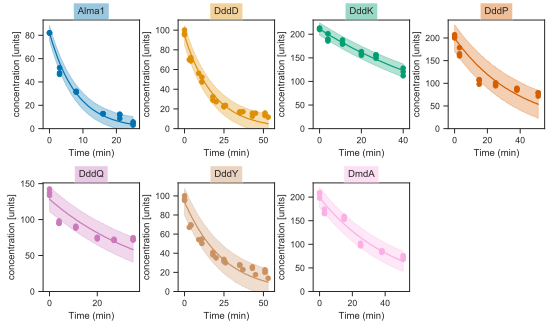

In [23]:
# Group data by enzyme
df_group = df.groupby("Name")

# Define colors
colors = sns.color_palette("colorblind", n_colors=len(df_group))
# Initialize figure
fig, ax = plt.subplots(2, 4, figsize=(9, 5))

# ravel ax
ax = ax.ravel()

# Loop through enzymes
for i, (enzyme, data) in enumerate(df_group):
    # Define MCMC file name
    file = f"../../data/mcmc/{enzyme}_mcmc.pkl"
    # read MCMC samples
    with open(file, 'rb') as f:
            samples_post = pickle.load(f)
            
    # Extract posterior predictive checks
    s_tilde = samples_post.posterior["s_tilde"].stack(
        {"sample": ("chain", "draw")}
    ).transpose("sample", "s_tilde_dim_0")

    t_sim = np.linspace(
        data["Time_min"].min(),
        data["Time_min"].max(),
        n_sim
    )
    # Plot credible region
    ax[i].fill_between(
        t_sim, 
        np.percentile(s_tilde, 50 - 95/2, axis=0),
        np.percentile(s_tilde, 50 + 95/2, axis=0),
        alpha=0.3,
        color=colors[i]
    )
    # Plot mode
    ax[i].plot(t_sim, np.percentile(s_tilde, 50, axis=0), color=colors[i])
    
    # Plot minus_ln_f_R vs d34S_approx_DMSP
    ax[i].scatter(data["Time_min"], data["Real_conc"], color=colors[i])
    
    # Set plot title
    ax[i].set_title(f"{enzyme}", bbox=dict(facecolor=colors[i], alpha=0.4))
    
    # Set axis labels
    ax[i].set_xlabel(r"Time (min)")
    ax[i].set_ylabel(r"concentration [units]")
    
    # Set plot ylim
    ax[i].set_ylim(bottom=0)
    
# Increase spacing among subplots
plt.subplots_adjust(hspace=0.5, wspace=0.4)

# Remove last plot
ax[-1].axis("off");

Although for the most part the fit seems not terrible, there are cases such as DddP, DddQ, and DddY that the trend definitely does not seem to follow the data as there are obvious systematic deviations.

As discussed in the paper, we have experimental reasons to believe that this is due to degradation of the enzyme as the experiment proceeds. We will now implement a model that includes this feature in order to see if we can recover the substrate dynamics for all enzymes.

## Irreversible enzyme kinetics with enzyme degradation

As mentioned before, experimental evidence discussed in the paper points at a fact that the enzymes are degrading as the reactions are taking place. Our original simple irreversible kinetics model did not account for this change in the catalytic capacity of the cell lysate over time. We can extend our simple model to account for enzyme degradation. What we need to do is to split the term $V_\max$ into two elements: the maximum catalytic activity per enzyme $v_\max$ and the amount of enzyme $E$, such that $V_\max \equiv v_\max E$. Furthermore we will have a second differential equation that tracks the amount of enzyme over time. We take this to be a first order reaction of the form
$$
\frac{dE}{dt} = - k E,
$$
where $k$ is the degradation rate of the enzyme. Now we have two coupled differential equations in our system, and a new parameter to include in the system. Since we don't know the original amount of enzyme in the lysate, we will work in units of the initial amount of enzyme. In other words, we will take $E(t=0) = 1$, and model how the fraction of initial enzyme decays over time. 

Our Bayesian inference from before still applies, all we need to add is an extra parameter $k$ to the inference. Just as for the original $V_\max$, we will assign a half-Normal prior to both $v_\max$ and $k$. The original `Stan` program we wrote then needs very little modifications. the file `michaelis_menten_degradation.stan` implements this program with the following required inputs:
```
// Inference information
int<lower=1> n_replicate;  // number of replicates
int<lower=1> n_sample;  // number of time samples
real t_sample[n_replicate, n_sample];  // time points observed
real s_[n_replicate, n_sample];  // data, substrate concentration
real t0;  // Initial time

//  Simulation information
int<lower=1> n_sim;  // number of time points for numerical integration
real t_sim[n_sim];  // time points for numerical integration

// Parameters for prior distributions
real vmax_param[2];  // parameters for prior dis. of V_max
real km_param[2];  // parameters for prior dis. of K_M
real s0_param[2];  // parameters for prior dis. of s0
real deg_param[2];  // parameters for prior dis. of enzyme degradation rate
real sigma_param[2];  // parameters for prior dis. of sigma^2 
```

Let's first compile the code.

In [24]:
sm_deg = cmdstanpy.CmdStanModel(stan_file='stan_files/michaelis_menten_degradation.stan')

INFO:cmdstanpy:compiling stan program, exe file: /Users/mrazomej/git/DMSP/code/analysis/stan_files/michaelis_menten_degradation
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/mrazomej/git/DMSP/code/analysis/stan_files/michaelis_menten_degradation


Now let's take one of the example enzymes that didn't work very well in the previous iteration of the model to see if this extra feature improves our inference.

First we gather the required inputs.

In [26]:
# Define example enzyme
enzyme = "DddP"

# Extract example dataset
df_example = df[(df.Name == enzyme)]

# Group by replicate
df_group = df_example.groupby("Replicate")

# Extract number of samples per group
n_replicate = len(df_group)

# Extract number of samples per replicate
n_sample = [len(d.Time_min.unique()) for g, d in df_group][0]

# Set time and sample array
t_sample = np.zeros([n_replicate, n_sample])
s_ = np.zeros([n_replicate, n_sample])
for i, (g, d) in enumerate(df_group):
    # Sort data by time
    d = d.sort_values(by="Time_min")
    t_sample[i, :] = d.Time_min
    s_[i, :] = d.Real_conc

# Define initial time slightly below zero (required by Stan)
t0 = float(df_example.Time_min[0]- 1E-6)

# Define number of points for posterior predictive checks
n_sim = 200
# Define time points for posterior predictive checks
t_sim = [float(x) for x in
        np.linspace(
        df_example.Time_min.min(), df_example.Time_min.max(), n_sim
            )
        ]
# Extract values for the K_M prior
km_param = [
    float(df_km[df_km.enzyme == enzyme]["km"].values[0]),
    df_km[df_km.enzyme == enzyme]["sd_km"].values[0]
]
if np.isnan(km_param[1]):
    km_param[1] = km_param[0] * 0.1
else:
    km_param[1] = float(km_param[1])

# Extract parameters for initial concentration
s0_param = [float(s_[:, 0].mean()), float(s_[:, 0].std())]

# Define parameters for enzyme degradation rate prior
deg_param = [0, 10]

# Extract parameters for sigma
sigma_param = [0, s_.std(axis=0).mean()]

data = {
    "n_sample": n_sample,
    "n_replicate": n_replicate,
    "t_sample": t_sample,
    "s_": s_,
    "t0": t0,
    "n_sim": n_sim,
    "t_sim": t_sim,
    "vmax_param": [0, 1000],
    "km_param": km_param,
    "s0_param": s0_param,
    "deg_param": deg_param,
    "sigma_param": sigma_param,
}

Now we can sample out of this new posterior distribution.

In [27]:
# Define initial conditions
samples = sm_deg.sample(
    data=data,
    chains=6,
    iter_warmup=1500,
    iter_sampling=1500,
)

# Convert samples to ArViz object
samples_post = az.from_cmdstanpy(posterior=samples)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:start chain 5
INFO:cmdstanpy:start chain 6
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 6
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 5


And just as before we can take a look at the simulated data to see how well it compares with the actual experimental measurements. Again, we will plot the most probable value for the substrate kinetics as a solid line, and the 95% credible region as a light shaded area.

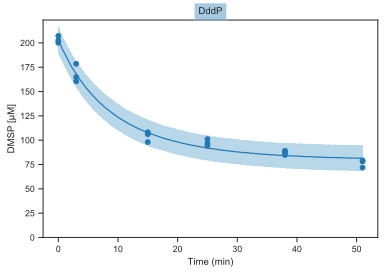

In [28]:
# Extract posterior predictive checks
s_tilde = samples_post.posterior["s_tilde"].stack(
    {"sample": ("chain", "draw")}
).transpose("sample", "s_tilde_dim_0")

# Define color
color = sns.color_palette("Paired", n_colors=2)
# Plot credible region
plt.fill_between(
    t_sim, 
    np.percentile(s_tilde, 50 - 95/2, axis=0),
    np.percentile(s_tilde, 50 + 95/2, axis=0),
    alpha=0.8,
    color=color[0]
)
# Plot mode
plt.plot(t_sim, np.percentile(s_tilde, 50, axis=0), color=color[1])

# Plot data
plt.plot(t_sample, s_, lw=0, marker="o", color=color[1])

# Set axis labels
plt.xlabel(r"Time (min)")
plt.ylabel(r"DMSP [µM]")

# Set title
plt.title(enzyme, bbox=dict(facecolor=color[1], alpha=0.4))

# Set y-axis limit
plt.ylim(bottom=0);

The theory-experiment agreement improved enormously. This then strongly suggests that the deviations we saw in the original inference can be explained by degradation of the enzyme.

Let's again extend this analysis to all enzymes.

In [29]:
# Group data by enzyme
df_group = df.groupby("Name")

# Loop through enzymes
for enzyme, data in df_group:
    print(enzyme)
    # Defien asmple name
    file = f"../../data/mcmc/{enzyme}_deg_mcmc.pkl"
    # Check if data already exists not to repeat the sample
    if os.path.isfile(file):
        continue
    else:
        # Group by replicate
        df_group = data.groupby("Replicate")

        # Extract number of samples per group
        n_replicate = len(df_group)

        # Extract number of samples per replicate
        n_sample = [len(d.Time_min.unique()) for g, d in df_group][0]

        # Set time and sample array
        t_sample = np.zeros([n_replicate, n_sample])
        s_ = np.zeros([n_replicate, n_sample])
        for i, (g, d) in enumerate(df_group):
            # Sort data by time
            d = d.sort_values(by="Time_min")
            t_sample[i, :] = d.Time_min
            s_[i, :] = d.Real_conc

        # Define initial time slightly below zero (required by Stan)
        t0 = float(data.Time_min[0]- 1E-6)

        # Define number of points for posterior predictive checks
        n_sim = 200
        # Define time points for posterior predictive checks
        t_sim = [float(x) for x in
                np.linspace(
                data.Time_min.min(), data.Time_min.max(), n_sim
                    )
                ]
        # Extract values for the K_M prior
        km_param = [
            float(df_km[df_km.enzyme == enzyme]["km"].values[0]),
            df_km[df_km.enzyme == enzyme]["sd_km"].values[0]
        ]
        if np.isnan(km_param[1]):
            km_param[1] = km_param[0] * 0.1
        else:
            km_param[1] = float(km_param[1])

        # Extract parameters for initial concentration
        s0_param = [float(s_[:, 0].mean()), float(s_[:, 0].std())]
        
        # Define parameters for enzyme degradation rate prior
        deg_param = [0, 10]

        # Extract parameters for sigma
        sigma_param = [0, s_.std(axis=0).mean()]

        data_stan = {
            "n_sample": n_sample,
            "n_replicate": n_replicate,
            "t_sample": t_sample,
            "s_": s_,
            "t0": t0,
            "n_sim": n_sim,
            "t_sim": t_sim,
            "vmax_param": [0, 1000],
            "km_param": km_param,
            "s0_param": s0_param,
            "deg_param": deg_param,
            "sigma_param": sigma_param,
        }
        print("Sampling with HMC")
        # Define initial conditions
        samples = sm_deg.sample(
            data=data_stan,
            chains=6,
            iter_warmup=1500,
            iter_sampling=1500,
        )

        # Convert samples to ArViz object
        samples_post = az.from_cmdstanpy(posterior=samples)
        
        with open(file, 'wb') as f:
            pickle.dump(samples_post, f)
        
        print("Done!")

Alma1
DddD
DddK
DddP
DddQ
DddY
DmdA


And now we can plot the posterior predictive checks for all of them simultaneously.

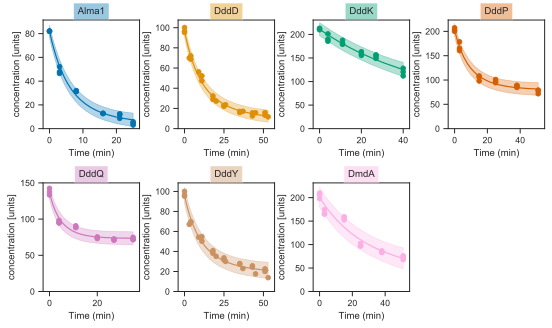

In [30]:
# Group data by enzyme
df_group = df.groupby("Name")

# Define colors
colors = sns.color_palette("colorblind", n_colors=len(df_group))
# Initialize figure
fig, ax = plt.subplots(2, 4, figsize=(9, 5))

# ravel ax
ax = ax.ravel()

# Loop through enzymes
for i, (enzyme, data) in enumerate(df_group):
    # Define MCMC file name
    file = f"../../data/mcmc/{enzyme}_deg_mcmc.pkl"
    # read MCMC samples
    with open(file, 'rb') as f:
            samples_post = pickle.load(f)
            
    # Extract posterior predictive checks
    s_tilde = samples_post.posterior["s_tilde"].stack(
        {"sample": ("chain", "draw")}
    ).transpose("sample", "s_tilde_dim_0")

    t_sim = np.linspace(
        data["Time_min"].min(),
        data["Time_min"].max(),
        n_sim
    )
    # Plot credible region
    ax[i].fill_between(
        t_sim, 
        np.percentile(s_tilde, 50 - 95/2, axis=0),
        np.percentile(s_tilde, 50 + 95/2, axis=0),
        alpha=0.3,
        color=colors[i]
    )
    # Plot mode
    ax[i].plot(t_sim, np.percentile(s_tilde, 50, axis=0), color=colors[i])
    
    # Plot minus_ln_f_R vs d34S_approx_DMSP
    ax[i].scatter(data["Time_min"], data["Real_conc"], color=colors[i])
    
    # Set plot title
    ax[i].set_title(f"{enzyme}", bbox=dict(facecolor=colors[i], alpha=0.4))
    
    # Set axis labels
    ax[i].set_xlabel(r"Time (min)")
    ax[i].set_ylabel(r"concentration [units]")
    
    # Set plot ylim
    ax[i].set_ylim(bottom=0)
    
# Increase spacing among subplots
plt.subplots_adjust(hspace=0.5, wspace=0.4)

# Remove last plot
ax[-1].axis("off");

Indeed all problematic cases from the previous iteration look significantly better given this extended model.